In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..', 'validate_assay'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from pcrvalidationtools import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Files 
DATA_PATH = "../Data/v4_08262024/"
datasets_file = DATA_PATH + 'ev_metadata_filtered.tsv'
assay0_file = DATA_PATH + 'ev_db/' + 'assay0.tsv'
assay1_file = DATA_PATH + 'ev_db/' + 'assay1.tsv'
assay2_file = DATA_PATH + 'ev_db/' + 'assay2.tsv'
assay8_file = DATA_PATH + 'ev_db/' + 'assay8.tsv'
collapse_taxonomy_file = DATA_PATH + 'ev_taxonomy_collapse.tsv'

In [4]:
# Retreive enterovirus, taxonomy group data
ev_data = pd.read_csv(datasets_file, sep='\t')
collapse_info = pd.read_csv(collapse_taxonomy_file, sep='\t')

# Get metadata for expected positive assay hits 
assay0 = assess_data(ev_data, get_accessions(assay0_file)) 
assay1 = assess_data(ev_data, get_accessions(assay1_file)) 
assay2 = assess_data(ev_data, get_accessions(assay2_file)) 
assay8 = assess_data(ev_data, get_accessions(assay8_file)) 

# Inputs 
assays = [assay0, assay1, assay2, assay8]
assay_names = ['Assay 0', 'Assay 1', 'Assay 2', 'Assay 8']
years = [2000, 2005, 2010, 2015, 2020, 2024]
virus_order = ['Enterovirus A', 'Enterovirus B', 'Enterovirus C', 'Enterovirus D', 
       'Rhinovirus A', 'Rhinovirus B', 'Rhinovirus C', 'unclassified Rhinovirus']

Combined summary for all assays 

In [5]:
summarize_assays(assays, assay_names, collapse_info)

,Virus Group,TaxID,Assay 0 Hits,Assay 1 Hits,Assay 2 Hits,Assay 8 Hits,Total
0,Enterovirus A,138948,1513,1508,1500,1510,1522
1,Enterovirus B,138949,453,448,467,448,468
2,Enterovirus C,138950,997,950,1006,999,1007
3,Enterovirus D,138951,6,6,537,6,537
4,Rhinovirus A,147711,0,0,158,0,684
5,Rhinovirus B,147712,0,0,5,0,118
6,Rhinovirus C,463676,6,0,65,0,339
7,unclassified Rhinovirus,348531,0,0,0,0,1


Collection timeplots for all assays

In [19]:
ev_taxids = collapse_info[collapse_info['Collapse Name'].str.contains('Enterovirus')]['Virus Taxonomic ID'].unique()

In [20]:
# Remove enterovirus data 
ev_taxids = collapse_info[collapse_info['Collapse Name'].str.contains('Enterovirus')]['Virus Taxonomic ID'].unique()
filtered_assays = [assay[assay['Virus Taxonomic ID'].isin(ev_taxids)] for assay in assays]

# Generate cumulative counts over time (collection and release year)  
all_year_counts = [count_years(assay_data) for assay_data in filtered_assays]
all_cumulative_counts = [make_cumulative(year_counts) for year_counts in all_year_counts]

# Retrieve collection data 
all_collection = [separate_year_types(cumulative_counts)[0] for cumulative_counts in all_cumulative_counts]

# Rename count column to assay name 
all_collection = [df.rename(columns={'Hit':assay_name}) for df, assay_name in zip(all_collection, assay_names)]

In [21]:
# Combine collection data for all assays 
combined = all_collection[0]
for df in all_collection[1:]:
    combined = combined.join(df[df.columns[1]])
combined

,Total,Assay 0,Assay 1,Assay 2,Assay 8
Collection Year,,,,,
1955,3.0,3.0,2.0,3.0,2.0
1956,3.0,3.0,2.0,3.0,2.0
1957,3.0,3.0,2.0,3.0,2.0
1958,3.0,3.0,2.0,3.0,2.0
1959,3.0,3.0,2.0,3.0,2.0
...,...,...,...,...,...
2020,3349.0,2869.0,2811.0,3325.0,2862.0
2021,3368.0,2887.0,2829.0,3344.0,2880.0
2022,3472.0,2908.0,2850.0,3448.0,2901.0


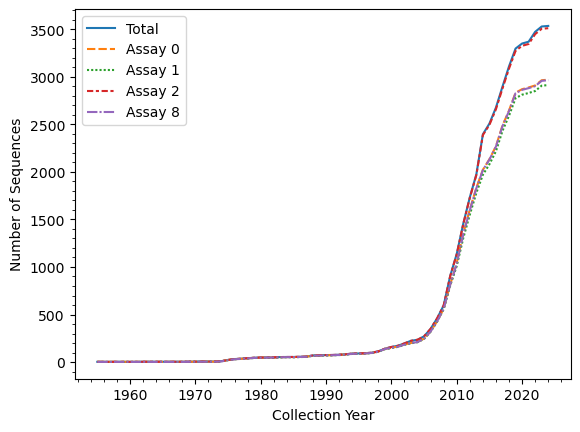

In [98]:
# Plot collection data 
sns.lineplot(data=combined, dashes=True)
plt.minorticks_on()
plt.ylabel('Number of Sequences');
plt.savefig('timeplot.svg', dpi=300, bbox_inches='tight')
# plt.title('Cumulative EV Sequences')

Text(0, 0.5, 'Number of Sequences')

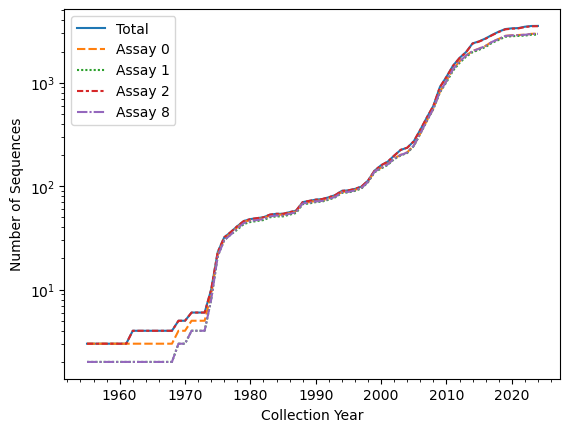

In [23]:
# Plot collection data (log scale)
sns.lineplot(data=combined, dashes=True)
plt.minorticks_on()
plt.yscale('log')
plt.ylabel('Number of Sequences')
# plt.title('Cumulative EV Sequences')

Heatmap for all assays 

In [51]:
# Generate heatmap total, ratio data for each assay (wide)
data = []

for assay in assays:
    # Get cumulative counts for each (species) group over collection year 
    aggregated = aggregate_counts(assay, years, collapse_info)
    
    # Reorder y-axis (optional)
    if virus_order:
        aggregated = aggregated.reindex(virus_order)
        
    data.append(calc_totals_ratios(aggregated))

In [49]:
data

[(                         2000   2005   2010    2015  2020  2024
  Virus Group                                                    
  Enterovirus A            17.0   48.0  268.0  1049.0  1490  1522
  Enterovirus B            40.0   51.0  138.0   254.0   420   468
  Enterovirus C            92.0  147.0  643.0   850.0   986  1007
  Enterovirus D            10.0   25.0   89.0   354.0   453   537
  Rhinovirus A              2.0    2.0   10.0    26.0    90   684
  Rhinovirus B              0.0    0.0    1.0     1.0    17   118
  Rhinovirus C              0.0    2.0   11.0    18.0    60   339
  unclassified Rhinovirus   0.0    0.0    0.0     0.0     1     1,
                           2000      2005      2010      2015      2020  \
  Virus Group                                                             
  Enterovirus A             1.0  1.000000  0.992537  0.993327  0.993960   
  Enterovirus B             1.0  0.980392  0.971014  0.948819  0.966667   
  Enterovirus C             1.0  1.0000

In [52]:
# Create long format data
long_data = []

for i, (total, ratio) in enumerate(data): 
    total = total.reset_index().melt(id_vars="Virus Group", var_name="Year", value_name="Total")
    ratio = ratio.reset_index().melt(id_vars="Virus Group", var_name="Year", value_name="Ratio")
    
    df = pd.merge(total, ratio, on=["Virus Group", "Year"])
    df['Assay'] = i + 1
    
    long_data.append(df)
    
final_df = pd.concat(long_data, ignore_index=True)

In [53]:
final_df

,Virus Group,Year,Total,Ratio,Assay
0,Enterovirus A,2000,17.0,1.000000,1
1,Enterovirus B,2000,40.0,1.000000,1
2,Enterovirus C,2000,92.0,1.000000,1
3,Enterovirus D,2000,10.0,0.200000,1
4,Rhinovirus A,2000,2.0,0.000000,1
...,...,...,...,...,...
187,Enterovirus D,2024,537.0,0.011173,4
188,Rhinovirus A,2024,684.0,0.000000,4
189,Rhinovirus B,2024,118.0,0.000000,4
190,Rhinovirus C,2024,339.0,0.000000,4


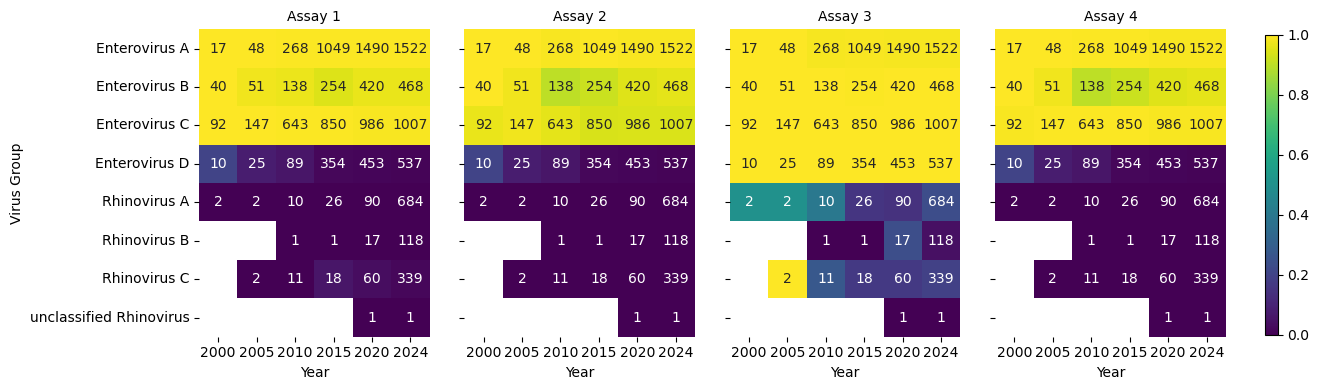

In [99]:
# Plot data on heatmap subplots 

def heatmap(data, **kwargs):
    pivot_ratio = data.pivot(index="Virus Group", columns="Year", values="Ratio")
    pivot_total = data.pivot(index="Virus Group", columns="Year", values="Total")
    
    ax = sns.heatmap(pivot_ratio, annot=pivot_total, fmt=".0f", cmap="viridis", cbar=False, vmin=0, vmax=1, square=True, **kwargs)
    
    return ax

g = sns.FacetGrid(final_df, col="Assay", height=4, aspect=.8)
g.map_dataframe(heatmap)

# Set up legend
cbar_ax = g.fig.add_axes([1, .15, .01, .75]) 
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0, vmax=1))
g.fig.colorbar(sm, cax=cbar_ax)

norm = mcolors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar_ax = g.fig.add_axes([1, 0.21, 0.02, 0.67]) 
cbar = g.fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Ratio')

# Edit subplot titles
g.set_titles("Assay {col_name}")

plt.savefig('heatmap.svg', dpi=300, bbox_inches='tight')
plt.show()